# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [8]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [9]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [10]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [11]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [18]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

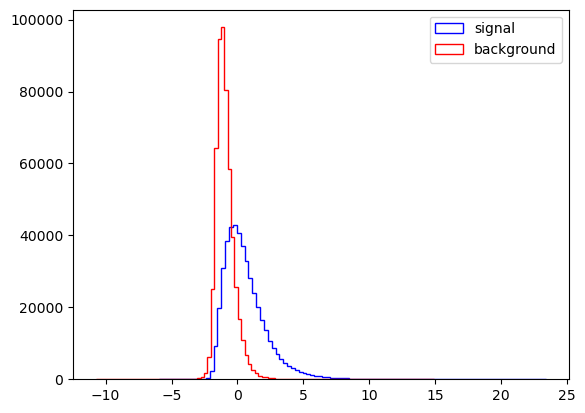

In [7]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

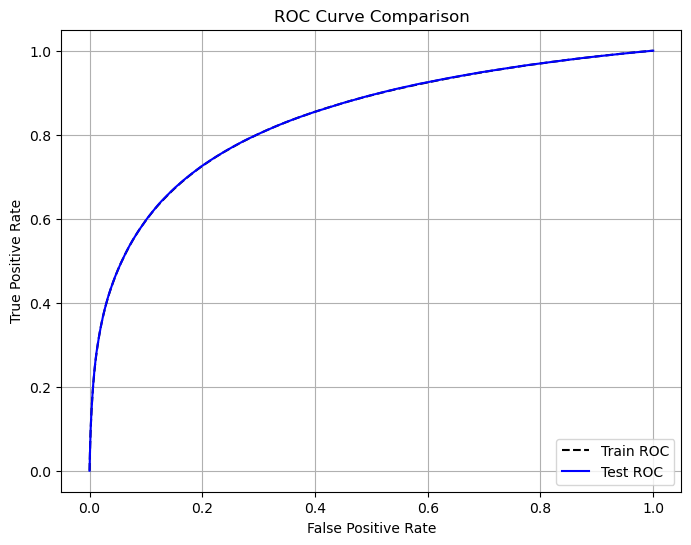

In [19]:
from sklearn.metrics import roc_curve

### Computing ROC curves
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

### Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label= "Train ROC", linestyle='--', color='black')
plt.plot(fpr_test, tpr_test, label= "Test ROC", linestyle='-', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

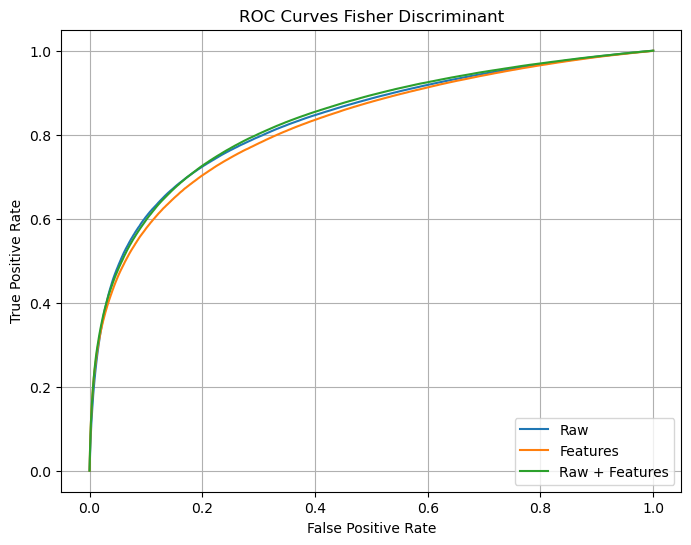

In [16]:
### Defining input features
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))
all = RawNames + FeatureNames

from sklearn.metrics import roc_curve
Fisher = DA.LinearDiscriminantAnalysis()

### Training model and getting ROC curve
def train_and_roc(features, label, title):
    Fisher.fit(X_Train[features], y_Train)
    y_score = Fisher.decision_function(X_Test[features])
    fpr, tpr, _ = roc_curve(y_Test, y_score)
    return fpr, tpr, title

### Collecting ROC data
roc_raw = train_and_roc(RawNames, y_Train, "Raw")
roc_features = train_and_roc(FeatureNames, y_Train, "Features")
roc_all = train_and_roc(all, y_Train, "Raw + Features")

### Plotting ROC curves
plt.figure(figsize=(8, 6))

for fpr, tpr, label in [roc_raw, roc_features, roc_all]:
    plt.plot(fpr, tpr, label=f"{label}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Fisher Discriminant")
plt.legend(loc= "lower right")
plt.grid()
plt.show()


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 7.

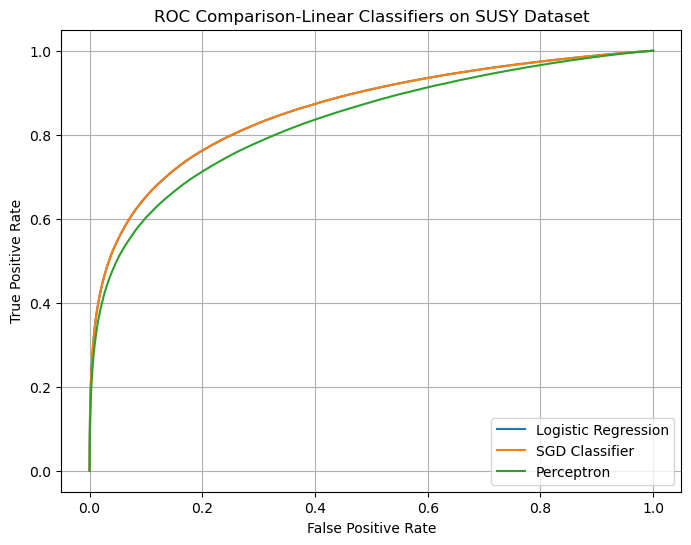

In [22]:
### Part a
""" - LogisticRegression 
    - SGDClassifier
    - Perceptron
"""

from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

all = RawNames + FeatureNames

### Traininf model and getting ROC curve
def train_and_plot(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    ### Generating prediction scores
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict(X_test)   ### Using predicting labels
    
    ### Computing TPR and FPR
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    return fpr, tpr, model_name

### Defining classifiers to compare
models = [(LogisticRegression(solver='lbfgs', max_iter=1000), "Logistic Regression"),
          (SGDClassifier(loss='log_loss', max_iter=1000), "SGD Classifier"),
          (Perceptron(max_iter=1000), "Perceptron")]

results = []

### Training each model and getting ROC curve
for model, name in models:
    fpr, tpr, label = train_and_plot(model, name, X_Train[all], y_Train, X_Test[all], y_Test)
    results.append((fpr, tpr, label))

### Plotting
plt.figure(figsize=(8, 6))

for fpr, tpr, label in results:
    plt.plot(fpr, tpr, label=f"{label}")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison-Linear Classifiers on SUSY Dataset")
plt.legend(loc="lower right")
plt.grid()
plt.show()

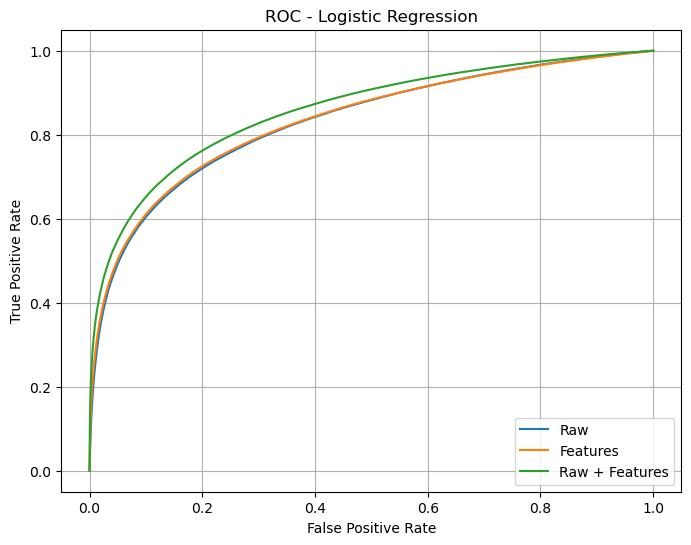

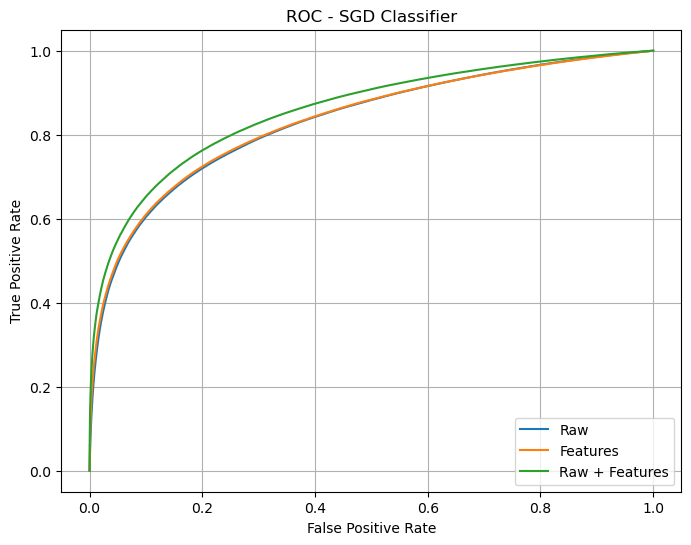

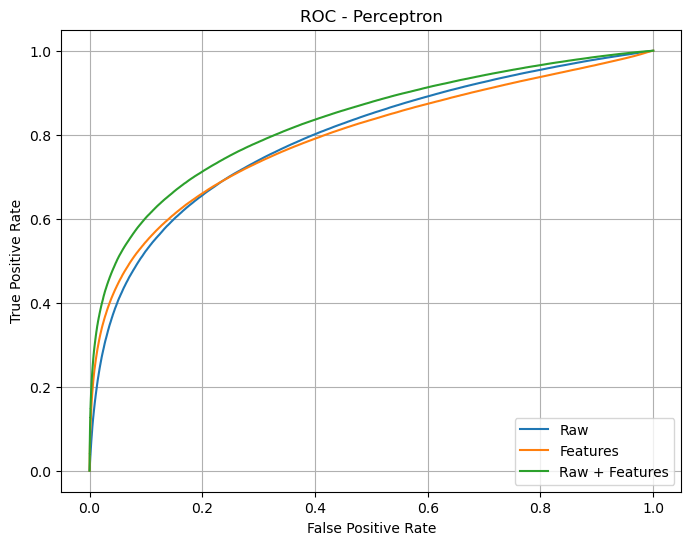

In [26]:
### Part b

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def compare_feature_sets(classifier, classifier_name):
    ### Defining feature sets
    RawNames = ["l_1_pT", "l_1_eta", "l_1_phi", 
                "l_2_pT", "l_2_eta", "l_2_phi", 
                "MET", "MET_phi"]
    
    FeatureNames = list(set(VarNames[1:]).difference(RawNames))
    all_features = RawNames + FeatureNames

    ### Training model and getting ROC
    def train_and_get_roc(features, title):
        classifier.fit(X_Train[features], y_Train)
        
        ### Generating prediction scores
        if hasattr(classifier, "decision_function"):
            y_scores = classifier.decision_function(X_Test[features])
        else:
            y_scores = classifier.predict(X_Test[features])
            
        ### Computing TPR and FPR
        fpr, tpr, _ = roc_curve(y_Test, y_scores)
        return fpr, tpr, title

    ### Collecting ROC data
    roc_raw = train_and_get_roc(RawNames, "Raw")
    roc_feat = train_and_get_roc(FeatureNames, "Features")
    roc_all = train_and_get_roc(all_features, "Raw + Features")

    ### Ploting
    plt.figure(figsize=(8, 6))
    for fpr, tpr, label in [roc_raw, roc_feat, roc_all]:
        plt.plot(fpr, tpr, label=f"{label}")
    
    plt.title(f"ROC - {classifier_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

### Running feature comparsion for each classifier   
compare_feature_sets(LogisticRegression(max_iter=1000), "Logistic Regression")
compare_feature_sets(SGDClassifier(loss='log_loss', max_iter=1000), "SGD Classifier")
compare_feature_sets(Perceptron(max_iter=1000), "Perceptron")

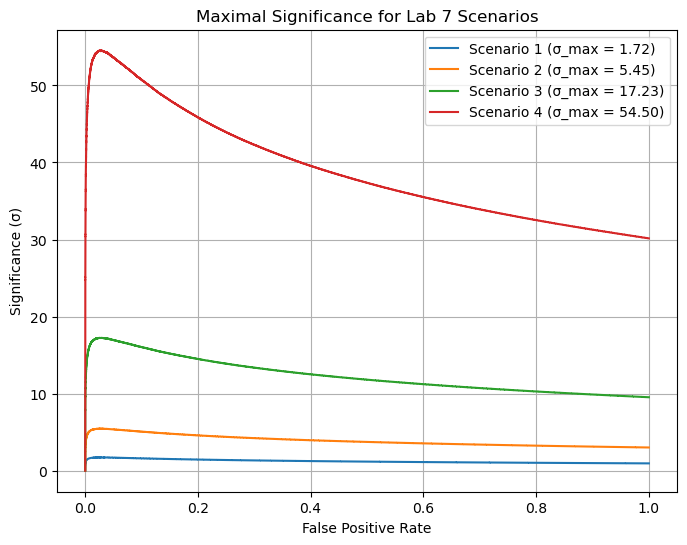

Scenario,N_S,N_B,TPR,FPR,N_S',N_B',Max σ,Threshold
1,10,100,0.475832,0.0286415,4.75832,2.86415,1.72348,0.767088
2,100,1000,0.475832,0.0286415,47.5832,28.6415,5.45012,0.767088
3,1000,10000,0.475832,0.0286415,475.832,286.415,17.2348,0.767088
4,10000,100000,0.475832,0.0286415,4758.32,2864.15,54.5012,0.767088


In [14]:
### Part c

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from IPython.display import HTML, display
import tabulate

def max_significance_from_classifier(classifierclass, model_args, X_train, y_train, X_test, y_test, scenarios, log_scale=False):
    
    ### Training classifier
    model = classifierclass(**model_args)
    model.fit(X_train, y_train)

    ### Generating prediction scores
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)

    ### Getting ROC metrics
    fpr, tpr, thresholds = roc_curve(y_test, scores)

    results_table = []
    plt.figure(figsize=(8, 6))

    for sid, (N_S, N_B) in scenarios.items():
        ### Scaling by TPR and FPR
        N_S_sel = tpr * N_S
        N_B_sel = fpr * N_B

        ### Calculating significance
        sigma = N_S_sel / np.sqrt(N_S_sel + N_B_sel + 1e-9)
        max_idx = np.argmax(sigma)
        max_sig = sigma[max_idx]

        ### Ploting curve
        plt.plot(fpr, sigma, label=f"Scenario {sid} (σ_max = {max_sig:.2f})")

        results_table.append([sid,
                              N_S,
                              N_B,
                              tpr[max_idx], 
                              fpr[max_idx],
                              N_S_sel[max_idx],
                              N_B_sel[max_idx],
                              max_sig,
                              thresholds[max_idx]])

    if log_scale:
        plt.yscale("log")

    plt.title("Maximal Significance for Lab 7 Scenarios")
    plt.xlabel("False Positive Rate")
    plt.ylabel("Significance (σ)")
    plt.legend()
    plt.grid(True)
    plt.show()

    ### Displaying metrics in a table
    headers = ["Scenario", "N_S", "N_B", "TPR", "FPR", "N_S'", "N_B'", "Max σ", "Threshold"]
    display(HTML(tabulate.tabulate(results_table, headers=headers, tablefmt="html")))

    return results_table

from sklearn.linear_model import LogisticRegression

lab7_scenarios = {"1": (10, 100),
                  "2": (100, 1000),
                  "3": (1000, 10000),
                  "4": (10000, 100000)}


results = max_significance_from_classifier(
    classifierclass=LogisticRegression,
    model_args={"max_iter": 1000},
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test,
    scenarios=lab7_scenarios,
    log_scale=False
)

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

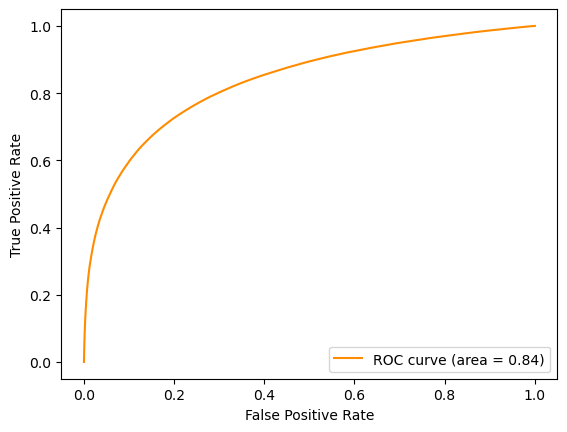

In [20]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


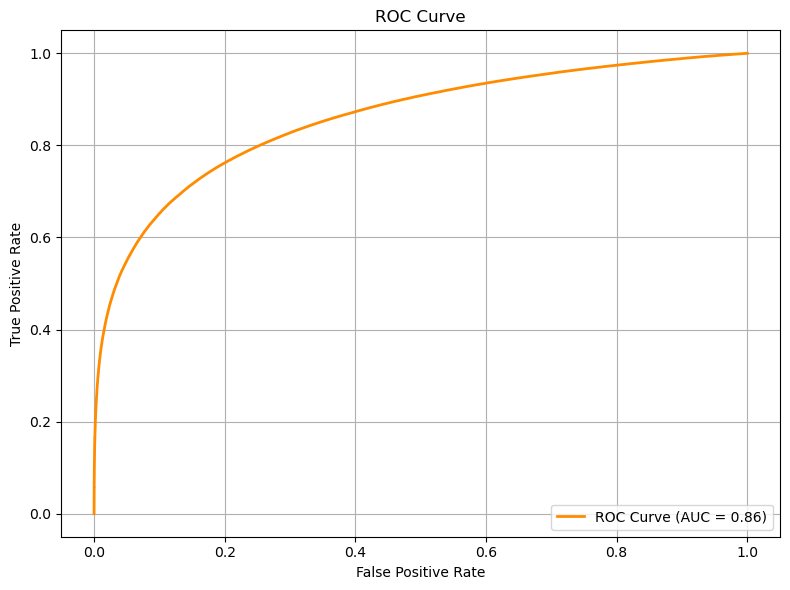

Scenario,N_S,N_B,TPR,FPR,Precision,Recall,F1,Accuracy,AUC,Max σ
1,10,100,0.475832,0.0286415,0.829581,0.677568,0.745908,0.788469,0.858159,1.72348
2,100,1000,0.475832,0.0286415,0.829581,0.677568,0.745908,0.788469,0.858159,5.45012
3,1000,10000,0.475832,0.0286415,0.829581,0.677568,0.745908,0.788469,0.858159,17.2348
4,10000,100000,0.475832,0.0286415,0.829581,0.677568,0.745908,0.788469,0.858159,54.5012


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from IPython.display import HTML, display

def evaluate_metrics(model, X_train, y_train, X_test, y_test, scenarios):
    
    model.fit(X_train, y_train)         ### Training model

    ### Generating prediction scores
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_Test)[:, 1]
    else:
        scores = model.decision_function(X_Test)

    ### Computing ROC curve and AUC value   
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)

    ### Predicting hard class labels using 0.5 threshold
    preds = (scores >= 0.5).astype(int)

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    
    ### Plotting ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    results = []

    for sid, (N_S, N_B) in scenarios.items():
        ### Scaling by TRP and FRP
        N_S_scaled = N_S * tpr
        N_B_scaled = N_B * fpr

        ### Computing significance
        significance = N_S_scaled / np.sqrt(N_S_scaled + N_B_scaled + 1e-9)
        max_idx = np.argmax(significance)
        max_sigma = significance[max_idx]

        results.append([sid,
                        N_S, N_B,
                        tpr[max_idx], fpr[max_idx],
                        precision, 
                        recall,
                        f1, 
                        accuracy,
                        roc_auc,
                        max_sigma])

    ### Displaying metrics in Table
    headers = ["Scenario", "N_S", "N_B", "TPR", "FPR", "Precision", "Recall", "F1", "Accuracy", "AUC", "Max σ"]
    display(HTML(tabulate.tabulate(results, headers=headers, tablefmt="html")))


lab7_scenarios = {"1": (10, 100),
                  "2": (100, 1000),
                  "3": (1000, 10000),
                  "4": (10000, 100000)}

### Evaluating model performance on all scenarios
evaluate_metrics(model=LogisticRegression(max_iter=1000),
                 X_train=X_Train,
                 y_train=y_Train,
                 X_test=X_Test,
                 y_test=y_Test,
                 scenarios=scenarios)